In [64]:
import networkx as nx
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import matplotlib.pyplot as plt
import seaborn as sns
import copy

First lets define some custom functions for grouping nodes in the same rack into 'communities' which will be positioned close together when the network is rendered.

See: https://stackoverflow.com/questions/65069624/networkx-cluster-nodes-in-a-circular-formation-based-on-node-color

In [65]:
# cluster layout
NODE_LAYOUT = nx.circular_layout
# NODE_LAYOUT = nx.spectral_layout

# rack layout
COMMUNITY_LAYOUT = nx.circular_layout
# COMMUNITY_LAYOUT = nx.spectral_layout

def partition_layout(g, partition, ratio=0.1):
    """
    Compute the layout for a modular graph.

    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        network to plot

    partition -- dict mapping node -> community or None
        Network partition, i.e. a mapping from node ID to a group ID.

    ratio: 0 < float < 1.
        Controls how tightly the nodes are clustered around their partition centroid.
        If 0, all nodes of a partition are at the centroid position.
        if 1, nodes are positioned independently of their partition centroid.

    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition)

    pos_nodes = _position_nodes(g, partition)
    pos_nodes = {k : ratio * v for k, v in pos_nodes.items()}

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos


def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = COMMUNITY_LAYOUT(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos


def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges


def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """
    communities = dict()
    for node, community in partition.items():
        if community in communities:
            communities[community] += [node]
        else:
            communities[community] = [node]

    pos = dict()
    for community, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = NODE_LAYOUT(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos


def _layout(networkx_graph):
    edge_list = [edge for edge in networkx_graph.edges]
    node_list = [node for node in networkx_graph.nodes]

    pos = circular_layout(edge_list)

    # NB: some nodes might not be connected and hence will not be in the edge list.
    # Assuming a [0, 0, 1, 1] canvas, we assign random positions on the periphery
    # of the existing node positions.
    # We define the periphery as the region outside the circle that covers all
    # existing node positions.
    xy = list(pos.values())
    centroid = np.mean(xy, axis=0)
    delta = xy - centroid[np.newaxis, :]
    distance = np.sqrt(np.sum(delta**2, axis=1))
    radius = np.max(distance)

    connected_nodes = set(_flatten(edge_list))
    for node in node_list:
        if not (node in connected_nodes):
            pos[node] = _get_random_point_on_a_circle(centroid, radius)

    return pos


def _flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]


def _get_random_point_on_a_circle(origin, radius):
    x0, y0 = origin
    random_angle = 2 * np.pi * np.random.random()
    x = x0 + radius * np.cos(random_angle)
    y = y0 + radius * np.sin(random_angle)
    return np.array([x, y])

Now lets build the network...

In [66]:
nodes_per_rack = 3
racks_per_group = 3
num_groups = 3
    
def gen_node_name(group, rack, node):
    return f'g{group}_r{rack}_n{node}'

{'g0_r0_n0': array([1.00000000e+00, 3.31136915e-09]), 'g0_r0_n1': array([0.97304487, 0.23061587]), 'g0_r0_n2': array([0.89363265, 0.4487992 ]), 'g0_r1_n0': array([0.76604444, 0.64278758]), 'g0_r1_n1': array([0.59715855, 0.80212319]), 'g0_r1_n2': array([0.39607975, 0.91821611]), 'g0_r2_n0': array([0.17364822, 0.98480773]), 'g0_r2_n1': array([-0.05814482,  0.99830818]), 'g0_r2_n2': array([-0.28680324,  0.95798952]), 'g1_r0_n0': array([-0.50000006,  0.86602539]), 'g1_r0_n1': array([-0.68624174,  0.7273736 ]), 'g1_r0_n2': array([-0.83548772,  0.54950911]), 'g1_r1_n0': array([-0.93969261,  0.34202022]), 'g1_r1_n1': array([-0.99323833,  0.11609296]), 'g1_r1_n2': array([-0.99323833, -0.11609289]), 'g1_r2_n0': array([-0.93969261, -0.34202015]), 'g1_r2_n1': array([-0.83548778, -0.54950898]), 'g1_r2_n2': array([-0.68624157, -0.72737366]), 'g2_r0_n0': array([-0.49999991, -0.86602544]), 'g2_r0_n1': array([-0.28680333, -0.95798945]), 'g2_r0_n2': array([-0.05814465, -0.99830818]), 'g2_r1_n0': array(

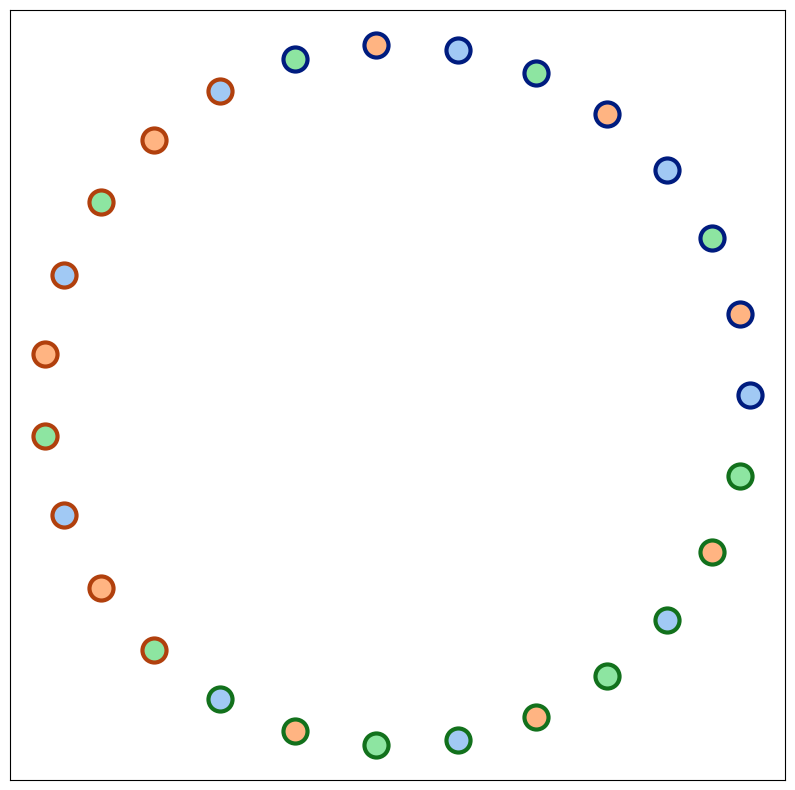

In [69]:
# init network
network = nx.DiGraph()

# populate network with nodes
for group in range(num_groups):
    for rack in range(racks_per_group):
        for node in range(nodes_per_rack):
            network.add_node(gen_node_name(group, rack, node))

# render
def render_network(network, 
                   connectionstyle='arc3',
                   arrowstyle='-|>',
                   node_color_palette='pastel',
                   node_edge_color_palette='dark',
                   node_linewidths=3,
                   figsize=(10, 10),
                   node_layout='circular'):
    fig = plt.figure(figsize=figsize)
    
    if node_layout == 'partition':
        partition, rack_id = {}, 0
        for group in range(num_groups):
            for rack in range(racks_per_group):
                for node in range(nodes_per_rack):
                    partition[gen_node_name(group, rack, node)] = rack_id
                rack_id += 1
        pos = partition_layout(network, partition)
    elif node_layout == 'circular':
        pos = nx.circular_layout(network)
    else:
        raise Exception(f'Unrecognised node_layout {node_layout}')
    print(pos)

    node_to_color = sns.color_palette(node_color_palette)
    group_to_color = sns.color_palette(node_edge_color_palette)
    
    for group in range(num_groups):
        for rack in range(racks_per_group):
            for node in range(nodes_per_rack):
                nodes = nx.draw_networkx_nodes(network,
                                               pos,
                                               nodelist=[gen_node_name(group, rack, node)],
                                               node_color=node_to_color[node],
                                               linewidths=node_linewidths)
                nodes.set_edgecolor(group_to_color[group])
    
    nx.draw_networkx_edges(network,
                           pos,
                           connectionstyle=connectionstyle,
                           arrowstyle=arrowstyle)
    
    plt.show()
    
render_network(network)

pos[node_name] = [x, y]

# Stage 1

{'g0_r0_n0': array([1.00000000e+00, 3.31136915e-09]), 'g0_r0_n1': array([0.97304487, 0.23061587]), 'g0_r0_n2': array([0.89363265, 0.4487992 ]), 'g0_r1_n0': array([0.76604444, 0.64278758]), 'g0_r1_n1': array([0.59715855, 0.80212319]), 'g0_r1_n2': array([0.39607975, 0.91821611]), 'g0_r2_n0': array([0.17364822, 0.98480773]), 'g0_r2_n1': array([-0.05814482,  0.99830818]), 'g0_r2_n2': array([-0.28680324,  0.95798952]), 'g1_r0_n0': array([-0.50000006,  0.86602539]), 'g1_r0_n1': array([-0.68624174,  0.7273736 ]), 'g1_r0_n2': array([-0.83548772,  0.54950911]), 'g1_r1_n0': array([-0.93969261,  0.34202022]), 'g1_r1_n1': array([-0.99323833,  0.11609296]), 'g1_r1_n2': array([-0.99323833, -0.11609289]), 'g1_r2_n0': array([-0.93969261, -0.34202015]), 'g1_r2_n1': array([-0.83548778, -0.54950898]), 'g1_r2_n2': array([-0.68624157, -0.72737366]), 'g2_r0_n0': array([-0.49999991, -0.86602544]), 'g2_r0_n1': array([-0.28680333, -0.95798945]), 'g2_r0_n2': array([-0.05814465, -0.99830818]), 'g2_r1_n0': array(

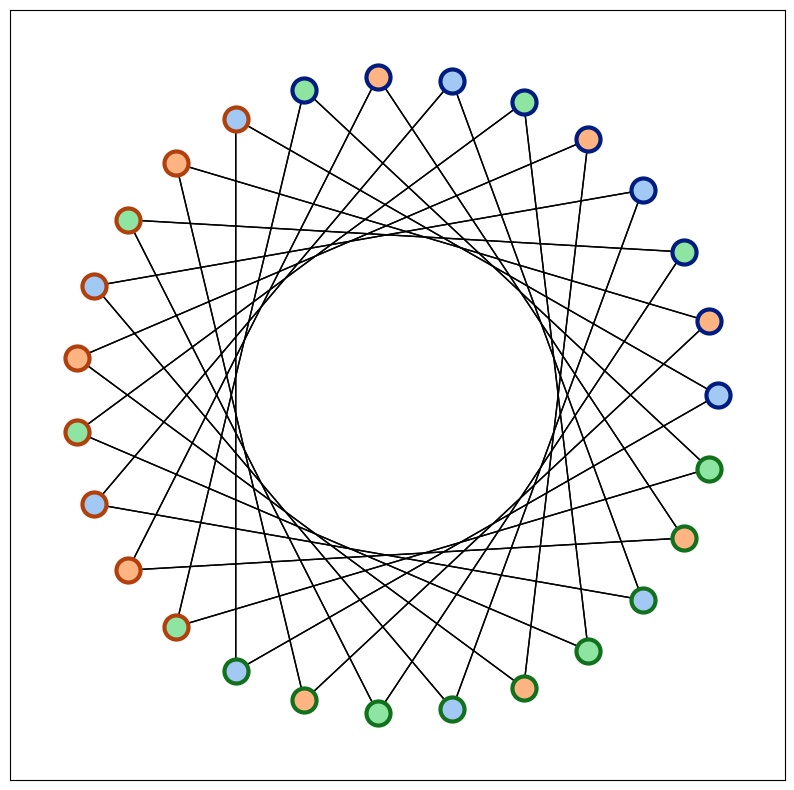

In [72]:
# connect edges
def connect_stage_one(network):
    stage_one_network = copy.deepcopy(network)
    for group in range(num_groups):
        # connect each node in group to corresponding node in all other groups
        for rack in range(racks_per_group):
            for node in range(nodes_per_rack):
                for _group in range(num_groups):
                    if group != _group:
                        stage_one_network.add_edge(gen_node_name(group, rack, node), gen_node_name(_group, rack, node))
    return stage_one_network
                    
stage_one_network = connect_stage_one(network)
render_network(stage_one_network, arrowstyle='-', connectionstyle='arc3', node_layout='circular')
# render_network(stage_one_network, arrowstyle='-', connectionstyle='arc3,rad=0.1', node_layout='partition')

In [ ]:
def connect_stage_two(network):
    pass